## Kickstarter Project Exploration

Explore cancer projects from Kickstarter

In [1]:
import os.path as op

import numpy as np
import json

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
pd.options.display.max_columns = 100

from scipy.stats import ttest_ind

import statsmodels.api as sm

In [2]:
DATA_PROCESSED = '../data/processed'

In [3]:
data = pd.read_csv(op.join(DATA_PROCESSED, 'cancer_projects_full.csv'))

data.sample(5)

,id,name,blurb,created,launched,deadline,goal,spotlight,staff_pick,status,status_changed_at,backers,usd_pledged,pledged,currency,current_currency,fx_rate,category,geo_country,geo_state,geo_type,url,text,mean_donation,text_length_chars,text_length_words,text_length_sentences,pledged_to_goal,duration,month,day_of_week,year,from_US,from_Town,blurb_length_words
193,1208203509,MARIANNE,A man takes his cancer-stricken wife to a pent...,2015-01-04 00:52:35,2015-01-04 16:20:25,2015-01-26 23:00:00,5000,False,False,failed,1422313212,58,5625.788508,3670.0,GBP,USD,1.305277,film & video,GB,England,Town,https://www.kickstarter.com/projects/266726441...,NaN,96.996354,0,0,0,0.734000,22 days 06:39:35.000000000,1,6,2015,0,1,20
218,939180409,pauir - Changing the lives of women with breas...,Women affected by breast cancer can now fit ea...,2014-04-15 17:58:02,2014-10-15 00:40:33,2014-11-28 04:59:00,15000,True,False,successful,1417150742,177,16136.000000,16136.0,USD,USD,1.000000,fashion,US,KY,Town,https://www.kickstarter.com/projects/scarweary...,And for those who are fortunate to never endur...,91.163842,981,184,9,1.075733,44 days 04:18:27.000000000,10,2,2014,1,1,24
301,116374896,SUSPICIOUS DENSITIES,A celebration of life and of those who face th...,2011-12-12 19:13:42,2012-01-14 00:21:45,2012-02-13 00:21:45,7000,True,False,successful,1329092506,68,7170.000000,7170.0,USD,USD,1.000000,film & video,US,DC,Town,https://www.kickstarter.com/projects/113218348...,20 years ago I lost my best friend to Stage 4 ...,105.441176,1087,194,13,1.024286,30 days 00:00:00.000000000,1,5,2012,1,1,26
73,1459261341,Pacific Crest Trail hike to write poetry -Outs...,"To hike the PCT writing poetry, celebrate my 5...",2015-05-01 01:34:49,2015-05-21 15:10:27,2015-05-23 05:27:00,5000,False,False,failed,1432358822,0,0.000000,0.0,USD,USD,1.000000,publishing,US,CA,Town,https://www.kickstarter.com/projects/27609132/...,I want to write a poetry book about cancer su...,0.000000,439,89,6,0.000000,1 days 14:16:33.000000000,5,3,2015,1,1,26
442,1868025474,Comics for good - Next Book: Cancer in the Family,Help us make the next book to help kids in fam...,2016-04-01 17:40:39,2016-04-26 21:10:08,2016-05-26 21:10:08,60000,False,False,failed,1464297008,34,1001.519211,6632.0,DKK,USD,0.167192,comics,DK,Midtjylland,Town,https://www.kickstarter.com/projects/266424214...,Our idea with Comics For Good is to make comic...,29.456447,3165,591,26,0.110533,30 days 00:00:00.000000000,4,1,2016,0,1,13


In [4]:
data.shape

(455, 35)

Clean out projects not classified as Success or Fail

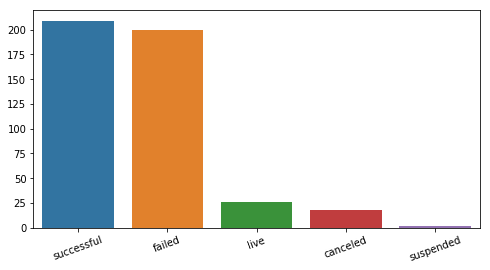

In [5]:
cnt = data['status'].value_counts()
plt.subplots(figsize=(8,4))
sns.barplot(cnt.index, cnt.values)
plt.xticks(rotation=20);

In [6]:
data = data[data['status'].isin(['successful', 'failed'])]
data['status'] = data['status'].apply(lambda r: 1 if r == 'successful' else 0)
data.shape

(409, 35)

Popular Country of Origin

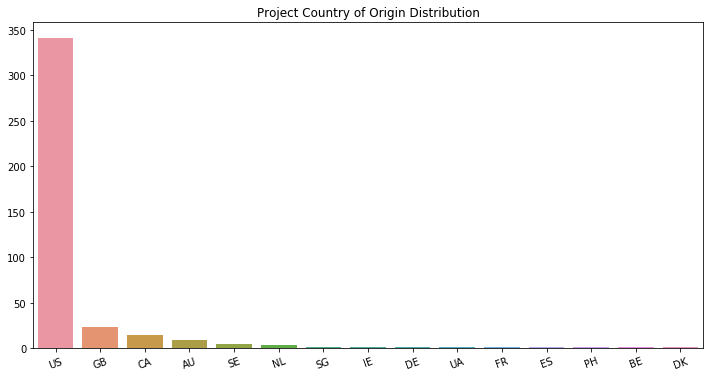

In [7]:
cnt = data['geo_country'].value_counts()
plt.subplots(figsize=(12,6))
sns.barplot(cnt.index, cnt.values)
plt.xticks(rotation=20)
plt.title('Project Country of Origin Distribution');

Popular Project Parent Categories

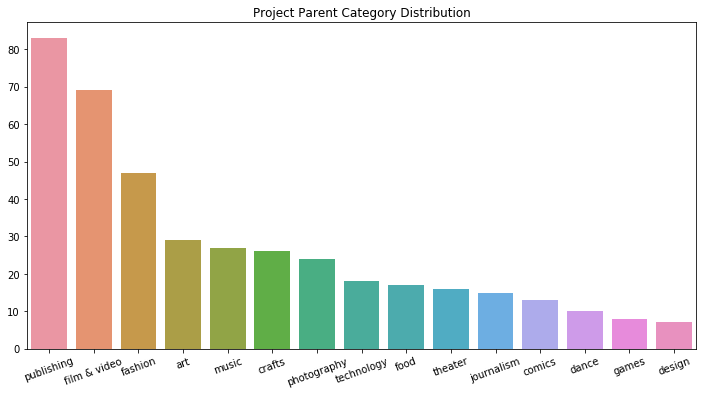

In [8]:
cnt = data['category'].value_counts()
plt.subplots(figsize=(12,6))
sns.barplot(cnt.index, cnt.values)
plt.xticks(rotation=20)
plt.title('Project Parent Category Distribution');

Geo Types

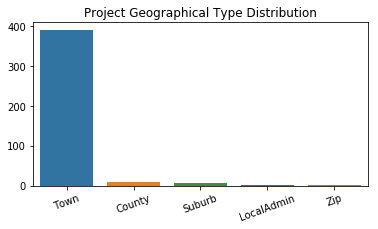

In [9]:
cnt = data['geo_type'].value_counts()
plt.subplots(figsize=(6,3))
sns.barplot(cnt.index, cnt.values)
plt.xticks(rotation=20)
plt.title('Project Geographical Type Distribution');

Duration

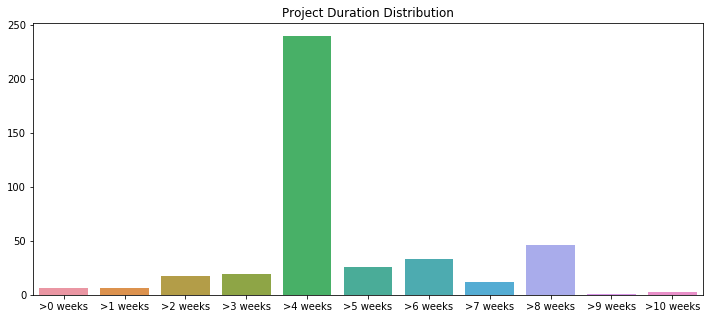

In [10]:
plt.subplots(figsize=(12,5))
td = pd.Series([ pd.Timedelta(days=i) for i in range(0, 92, 7)])
r = pd.cut(pd.TimedeltaIndex(data['duration'], unit='s').to_series(), td, labels=False).value_counts()
g = sns.barplot(r.index, r.values)
g.set_xticklabels([f'>{int(w)} weeks' for w in td.dt.days / 7])
plt.title('Project Duration Distribution');

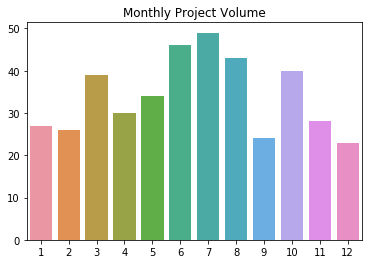

In [13]:
vc = data['month'].value_counts()
sns.barplot(vc.index, vc.values)
plt.title('Monthly Project Volume');